In [15]:
import pyhf
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
!curl -sL https://doi.org/10.17182/hepdata.89408.v1/r2  | tar -O -xzv RegionA/BkgOnly.json > lhood.json

x RegionA/BkgOnly.json


### Create the Model and Fit it

In [18]:
def make_model(channel_list):
    spec = json.load(open('lhood.json'))
    spec = copy.copy(spec)
    spec["channels"] = [c for c in spec["channels"] if c["name"] in channel_list]
    spec["measurements"][0]["config"]["poi"] = "lumi"

    w = pyhf.Workspace(spec)
    m = w.model(
        measurement_name="NormalMeasurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )
    d = w.data(m)
    return w, m, d

def fitresults():
    w, m, d = make_model(['CRtt_meff'])
    d = w.data(m)

    pyhf.set_backend(pyhf.tensor.numpy_backend(),pyhf.optimize.minuit_optimizer(verbose = True))
    minuit = pyhf.optimizer._make_minuit(
        pyhf.utils.loglambdav,
        d,
        m,
        m.config.suggested_init(),
        m.config.suggested_bounds()
    )
    result = minuit.migrad(ncall = 100000)
    bestfit = pyhf.tensorlib.astensor([x[1] for x in minuit.values.items()])
    errors = pyhf.tensorlib.astensor([x[1] for x in minuit.errors.items()])

    return m,d,bestfit,errors

m,data,bestfit,errors = fitresults()

## Normalize to natural width and order results

In [22]:
pulls = pyhf.tensorlib.concatenate([(bestfit[m.config.par_slice(k)] - m.config.param_set(k).suggested_init)/m.config.param_set(k).width() for k in m.config.par_order  if m.config.param_set(k).constrained])
pullerr = pyhf.tensorlib.concatenate([errors[m.config.par_slice(k)]/m.config.param_set(k).width() for k in m.config.par_order  if m.config.param_set(k).constrained])
labels = np.asarray(['{}[{}]'.format(k,i) if m.config.param_set(k).n_parameters > 1 else k  for k in m.config.par_order  if m.config.param_set(k).constrained for i in range(m.config.param_set(k).n_parameters)])

order = np.argsort(labels)
fitted = bestfit[order]
fiterr = errors[order]
labels = labels[order]
pulls = pulls[order]
pullerr = pullerr[order]

Text(0, 0.5, '(θ-θ̂)/Δθ')

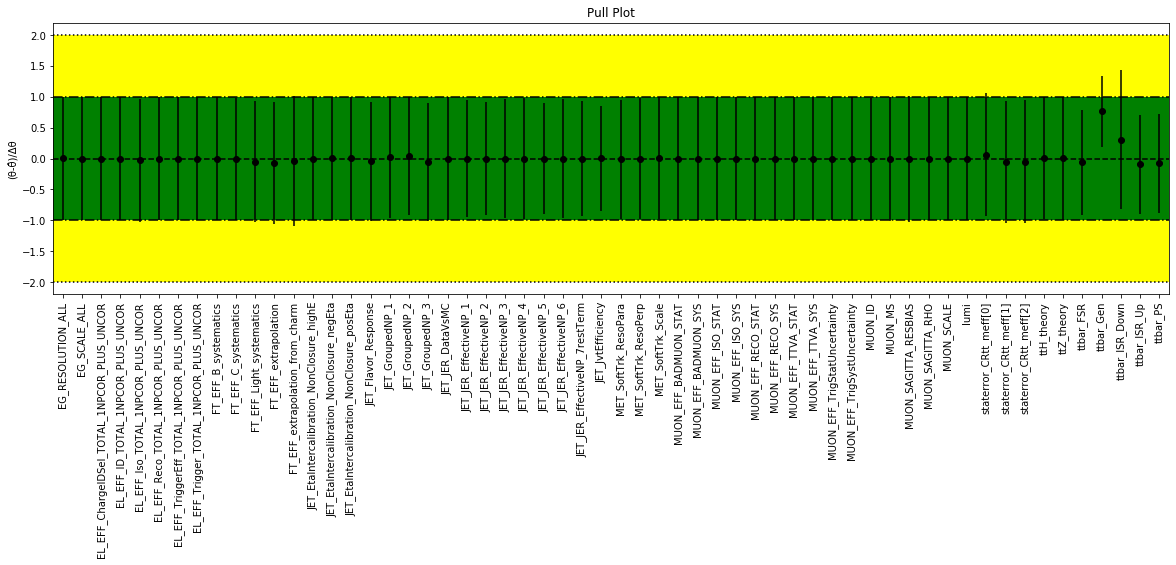

In [23]:
plt.hlines([-2,2],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dotted')
plt.hlines([-1,1],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dashdot')
plt.fill_between([-0.5,len(pulls)-0.5],[-2,-2],[2,2],facecolor = 'yellow')
plt.fill_between([-0.5,len(pulls)-0.5],[-1,-1],[1,1],facecolor = 'green')
plt.hlines([0],-0.5,len(pulls)-0.5, colors= 'k',linestyles = 'dashed')
plt.scatter(range(len(pulls)),pulls, c = 'k')
plt.errorbar(range(len(pulls)),pulls, c = 'k',xerr = 0, yerr = pullerr, marker = '.', fmt='none')
plt.xticks(range(len(pulls)),labels,rotation = 90);
plt.gcf().set_size_inches(20,5)
plt.xlim(-0.5,len(pulls)-0.5)
plt.title('Pull Plot')
plt.ylabel('(θ-θ̂)/Δθ')